In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs

import os
import time

plt.rcParams.update({'font.size':18})

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

## 参数设置

In [4]:
pi = np.pi
pf=1000;# kg/m-3
ps=2700;
pp=5540;
p=1000;# 水的密度
d31=-210e-12;
Cp=89.5e-9;
hp=0.3e-3;
hs=0.15e-3;
ha=-(hs+hp)/2;
hb=(hs-hp)/2;
hc=(hs+hp)/2;
Es=70e9; # KN/m2
Ep=15.857e9;# KN/m2
D=16e-3;
Lc=45e-3;
M0=0.01;
b=18e-3;
L=100e-3;
Mf=pf*pi*D**2*Lc/4+(33/140)*pi*pf*b**2*(L/4);
M=M0+Mf;
It=(M*(D/2)**2)/2;
m=ps*hs*b+pp*hp*b;
k1=0.086;# 阻尼比
K=b*(Es*(hb**3-ha**3)+Ep*(hc**3-hb**3))/3;
CD=2;
C1=0.3;
U=1;  # 速度
lam=1;
keci=0.3;
A=12;
St=0.2;
wf=2*pi*St*U/D;
R=0.5e6;

e31=-Ep*d31;
theta=-e31*b*(hc**2-hb**2)/(2*hp);
lamda=0.808646;
wn=lamda**2*(K/(m*L**4))**0.5; # 固有频率

#f_L=double(subs(f,x,L));
#df_L=double(subs(df,x,L));
#fi=(f_L+0.5*D*df_L);
f_L=-6.1894;
df_L=-92.8022;
fi=-6.9318;


In [5]:
domain = (0, 1.5, -0.0025, 0.0025)
tmin, tmax, xmin, xmax = domain
backbone_layers = [2] + [20]*4 + [1]
# nn_lam_layers = [1] + [20]*3 + [2]
adam_iters = 20000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [6]:
class Dataset:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, verbose=None):
        tmin, tmax, xmin, xmax = self.domain
        # 内部点采样
        t_res = np.linspace(tmin, tmax, 50)
        x_res = np.linspace(xmin, xmax, 80)
        X_res = self.sample_xy(t_res, x_res)
        
        X_res = np.expand_dims(X_res, axis=2)
        X_res = np.repeat(X_res,5,axis=2)
        
        # 初始点采样
        X_ics =self.sample_xy(np.array([tmin]), np.linspace(xmin, xmax, 100))
#         X_ics = np.concatenate([X_ics, self.sample_xy(np.array([tmin]), np.linspace(xmin,xmax,100))], axis=0)
        X_ics = np.expand_dims(X_ics, axis=2)
        X_ics = np.repeat(X_ics,5,axis=2)
        return X_res, X_ics
    
    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X

    
dataset = Dataset(domain)
X_res, X_ics = dataset.train_data()
# X_res_1 = X_res_2 =X_res_3 =X_res_4 =X_res_5 =X_res
print(X_res.shape, X_ics.shape)
X_res[:,1].max()

(4000, 2, 5) (100, 2, 5)


0.0025

## DNN

In [7]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)
    
backbone1 = MLP(backbone_layers)
backbone2 = MLP(backbone_layers)
backbone3 = MLP(backbone_layers)
backbone4 = MLP(backbone_layers)
backbone5 = MLP(backbone_layers)

# nn_lam = MLP(nn_lam_layers)

## 主干网络

In [8]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [9]:
class PINN(nn.Module):
    def __init__(self, backbone1, backbone2, backbone3, backbone4, backbone5, mu=None, sigma=None):
        super(PINN, self).__init__()
        self.backbone1 = backbone1
        self.backbone2 = backbone2
        self.backbone3 = backbone3
        self.backbone4 = backbone4
        self.backbone5 = backbone5

    def forward(self, X_res, X_ics):
        
        loss_res_1 = torch.mean(self.net_E1(X_res)** 2)
        loss_res_2 = torch.mean(self.net_E2(X_res)** 2)
        loss_res_3 = torch.mean(self.net_E3(X_res)** 2)
        loss_res_4 = torch.mean(self.net_E4(X_res)** 2)
        loss_res_5 = torch.mean(self.net_E5(X_res)** 2)
        loss_ics = torch.mean(self.net_ics(X_ics)**2)
        return loss_res_1, loss_res_2, loss_res_3, loss_res_4, loss_res_5, loss_ics 

    def net_pred1(self, X):
        return self.backbone1(X)
    
    def net_pred2(self, X):
        return self.backbone2(X)
    
    def net_pred3(self, X):
        return self.backbone3(X)
    
    def net_pred4(self, X):
        return self.backbone4(X)
    
    def net_pred5(self, X):
        return self.backbone5(X)
    
    def net_X_res_pred(self, X):
        X1_star = X[:,:,0]
        X2_star = X[:,:,1]
        X3_star = X[:,:,2]
        X4_star = X[:,:,3]
        X5_star = X[:,:,4]
        
        X1_star.requires_grad_(True)
        X2_star.requires_grad_(True)
        X3_star.requires_grad_(True)
        X4_star.requires_grad_(True)
        X5_star.requires_grad_(True)
        
        X1 = self.net_pred1(X1_star)
        X2 = self.net_pred2(X2_star)
        X3 = self.net_pred3(X3_star)
        X4 = self.net_pred4(X4_star)
        X5 = self.net_pred5(X5_star)
        return X1,X2,X3,X4,X5
        

    def net_E1(self, X):
        X.requires_grad_(True)
        
        X1_star = X[:,:,0]
        X2_star = X[:,:,1]
        X1_star.requires_grad_(True)
        X2_star.requires_grad_(True)
        
        X1 = self.net_pred1(X1_star)
        X2 = self.net_pred2(X2_star)

        grad_X1 = grad(X1, X1_star)[0]
        X1_pred_t = grad_X1[:, [0]]
        
        return X1_pred_t - X2  
    
    def net_E2(self,X):
        X1_star = X[:,:,0]
        X2_star = X[:,:,1]
        X3_star = X[:,:,2]
        X4_star = X[:,:,3]
        X5_star = X[:,:,4]
        
        X1_star.requires_grad_(True)
        X2_star.requires_grad_(True)
        X3_star.requires_grad_(True)
        X5_star.requires_grad_(True)

        X1 = self.net_pred1(X1_star)
        X2 = self.net_pred2(X2_star)
        X3 = self.net_pred3(X3_star)
        X5 = self.net_pred5(X5_star)
        
        grad_X = grad(X2, X2_star)[0]
        X2_pred_t = grad_X[:, [0]]
        
        return X2_pred_t + (2*k1*wn+0.5*CD*p*D*U*Lc*fi**2)*X2-wn**2*X1-theta*df_L*X5+0.25*C1*p*D*U**2*Lc*fi*X3
    
    def net_E3(self, X):
        X1_star = X[:,:,0]
        X2_star = X[:,:,1]
        X3_star = X[:,:,2]
        X4_star = X[:,:,3]
        X5_star = X[:,:,4]
        
        X1_star.requires_grad_(True)
        X3_star.requires_grad_(True)
        
        X3 = self.net_pred3(X3_star)
        X4 = self.net_pred4(X4_star)
        
        grad_X = grad(X3, X3_star)[0]
        X3_pred_t = grad_X[:, [0]]
        return X3_pred_t-X4
    
    def net_E4(self, X):
        X1_star = X[:,:,0]
        X2_star = X[:,:,1]
        X3_star = X[:,:,2]
        X4_star = X[:,:,3]
        X5_star = X[:,:,4]
        
        X4_star.requires_grad_(True)
        X1 = self.net_pred1(X1_star)
        X2 = self.net_pred2(X2_star)
        X3 = self.net_pred3(X3_star)
        X4 = self.net_pred4(X4_star)
        X5 = self.net_pred5(X5_star)
        
        grad_X = grad(X4, X4_star)[0]
        X4_pred_t = grad_X[:, [0]]
        
        return X4_pred_t - (-lam*keci*wf*(X3)**2*X4+lam*keci*wf*X4-wf**2*X3+A/D*fi*(-(2*k1*wn+0.5*CD*p*D*U*Lc*fi**2)*X2-wn**2*X1-theta*df_L*X5+0.25*C1*p*D*U**2*Lc*fi*X3))
    
    def net_E5(self,X):
        X1_star = X[:,:,0]
        X2_star = X[:,:,1]
        X3_star = X[:,:,2]
        X4_star = X[:,:,3]
        X5_star = X[:,:,4]
        
        X4_star.requires_grad_(True)
        X2 = self.net_pred2(X2_star)
        X5 = self.net_pred5(X5_star)
        
        grad_X = grad(X5, X5_star)[0]
        X5_pred_t = grad_X[:, [0]]
        
        return X5_pred_t-((-X5/R+theta*df_L*X2)/Cp)
        
    def net_ics(self,X):
        X1 = X[:,1,0]
        X2 = X[:,1,1:]
        X1 = np.add(X1, -np.ones((X1.shape))*0.0002).reshape((-1,1))
        X_ics = torch.cat((X1,X2),1)
        return X_ics
        
pinn = PINN(backbone_layers,backbone_layers,backbone_layers,backbone_layers,backbone_layers)
# pinn.net_E1(torch.tensor(X_res_1),torch.tensor(X_res_2))

## Adam

In [10]:
dataset = Dataset(domain)
X_res, X_ics = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_ics = torch.from_numpy(X_ics).float().to(device)

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone1 = MLP(backbone_layers)  # 主干网络
backbone2 = MLP(backbone_layers)
backbone3 = MLP(backbone_layers)
backbone4 = MLP(backbone_layers)
backbone5 = MLP(backbone_layers)
pinn = PINN(backbone1, backbone2, backbone3, backbone4, backbone5, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率
logger = {
    "loss": [], 
    "loss_res_1": [],
    "loss_res_2": [],
    "loss_res_3": [],
    "loss_res_4": [],
    "loss_res_5": [],
    "loss_ics": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    # 计算loss并更新网络 -------
    pinn.train()
    pinn.zero_grad()
    
    loss_res_1, loss_res_2, loss_res_3, loss_res_4, loss_res_5, loss_ics   = pinn(X_res, X_ics)
    loss = loss_res_1 + 100*loss_res_2 + loss_res_3 + 100*loss_res_4 + 100*loss_res_5 + loss_ics 
    
    loss.backward()
    optimizer_adam.step()
#     optimizer_adam_lam.step()
    # 计算loss并更新网络 -------
    
    
    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_res_1_valid, loss_res_2_valid, loss_res_3_valid, loss_res_4_valid, loss_res_5_valid, loss_ics_valid  = pinn(X_res, X_ics)
        loss_valid = loss_res_1_valid + loss_res_2_valid + loss_res_3_valid + loss_res_4_valid + loss_res_4_valid + loss_ics_valid
        
        logger["loss"].append(loss_valid.item())
        logger["loss_res_1"].append(loss_res_1_valid.item())
        logger["loss_res_2"].append(loss_res_2_valid.item())
        logger["loss_res_3"].append(loss_res_3_valid.item())
        logger["loss_res_4"].append(loss_res_4_valid.item())
        logger["loss_res_5"].append(loss_res_5_valid.item())
        logger["loss_ics"].append(loss_ics_valid.item())
        logger["iter"].append(it+1)
        
        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it+1, 'backbone_state': pinn.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()
        
        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it+1:6d}/{adam_iters}\t' + \
                f'loss:{loss.item():.2e}, loss_r_1:{loss_res_1.item():.2e}, loss_r_2:{loss_res_2.item():.2e}, loss_r_3:{loss_res_3.item():.2e},loss_r_4:{loss_res_4.item():.2e},loss_r_5:{loss_res_5.item():.2e} loss_i:{loss_ics.item():.2e}  ' + \
                f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_res_1_valid.item():.2e}, loss_i:{loss_ics_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
            
        # 衰减学习率
        if (it + 1) % 4000 == 0:
            lr_sche.step()
#             lr_sche_lam.step()

Iter #    500/20000	loss:1.82e+06, loss_r_1:4.74e-03, loss_r_2:2.93e+01, loss_r_3:1.21e-03,loss_r_4:3.50e+03,loss_r_5:1.47e+04 loss_i:2.13e-06  Valid # loss:6.99e+03, loss_r:4.74e-03, loss_i:2.13e-06
Iter #   1000/20000	loss:4.37e+05, loss_r_1:4.46e-03, loss_r_2:2.76e+01, loss_r_3:1.19e-03,loss_r_4:6.98e+02,loss_r_5:3.65e+03 loss_i:2.13e-06  Valid # loss:1.42e+03, loss_r:4.46e-03, loss_i:2.13e-06
Iter #   1500/20000	loss:3.74e+05, loss_r_1:4.41e-03, loss_r_2:2.73e+01, loss_r_3:1.18e-03,loss_r_4:5.75e+02,loss_r_5:3.14e+03 loss_i:2.13e-06  Valid # loss:1.18e+03, loss_r:4.41e-03, loss_i:2.13e-06
Iter #   2000/20000	loss:3.37e+05, loss_r_1:4.42e-03, loss_r_2:2.73e+01, loss_r_3:1.16e-03,loss_r_4:5.06e+02,loss_r_5:2.84e+03 loss_i:2.13e-06  Valid # loss:1.04e+03, loss_r:4.42e-03, loss_i:2.13e-06
Iter #   2500/20000	loss:2.96e+05, loss_r_1:4.35e-03, loss_r_2:2.67e+01, loss_r_3:1.09e-03,loss_r_4:5.65e+02,loss_r_5:2.37e+03 loss_i:2.13e-06  Valid # loss:1.37e+03, loss_r:4.35e-03, loss_i:2.13e-06


In [11]:
np.save("./logger.npy", logger)
model_state

{'iter': 15200,
 'backbone_state': OrderedDict([('backbone1.model.layer0.fc0.weight',
               tensor([[-0.0358,  0.0177],
                       [-0.0798, -0.2192],
                       [-0.0641, -0.3130],
                       [-0.4999,  0.3371],
                       [ 0.5578,  0.5608],
                       [ 0.2956,  0.2098],
                       [-0.3711, -0.4889],
                       [-0.3028,  0.6162],
                       [ 0.2283,  0.5697],
                       [ 0.0756, -0.3372],
                       [ 0.4132, -0.7416],
                       [ 0.1312,  0.3682],
                       [-0.3563, -0.0512],
                       [ 0.4759,  0.6426],
                       [-0.0650, -0.5644],
                       [ 0.1938, -0.4770],
                       [ 0.1055,  0.4573],
                       [-0.1772,  0.3956],
                       [ 0.0442, -0.5170],
                       [-0.5771, -0.2005]])),
              ('backbone1.model.layer0.fc0.bias',
 

# LBFGS

In [12]:
"""LBFGS训练"""
start_time = time.time()

dataset = Dataset(domain)
X_res, X_ics = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_ics = torch.from_numpy(X_ics).float().to(device)

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone1 = MLP(backbone_layers)  # 主干网络
backbone2 = MLP(backbone_layers)
backbone3 = MLP(backbone_layers)
backbone4 = MLP(backbone_layers)
backbone5 = MLP(backbone_layers)
pinn = PINN(backbone1, backbone2, backbone3, backbone4, backbone5, mu, sigma).to(device)

optimizer_lbfgs = optim.Adam(pinn.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.load_state_dict(model_state['backbone_state'])

optimizer_lbfgs = optim.LBFGS(pinn.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5)

loss_log_lbfgs = []
it = 0
with open(train_info_path + 'train_info.txt', 'a') as f:
    f.write('Training by LBFGS:\n')

def closure():
    global it, best_loss, adam_iters
    pinn.zero_grad()
    
    loss_res_1, loss_res_2, loss_res_3, loss_res_4, loss_res_5, loss_ics   = pinn(X_res, X_ics)
    loss = loss_res_1 + loss_res_2 + loss_res_3 +loss_res_4 + loss_res_5 + loss_ics 
    
    loss.backward()
    
    loss_log_lbfgs.append(loss.item())
    if (it + 1) % 100 == 0:
        pinn.train(False)  # 验证 -------
        pinn.train(False)
        loss_res_1_valid, loss_res_2_valid, loss_res_3_valid, loss_res_4_valid, loss_res_5_valid, loss_ics_valid  = pinn(X_res, X_ics)
        loss_valid = loss_res_1_valid + loss_res_2_valid + loss_res_3_valid + loss_res_4_valid + loss_res_4_valid + loss_ics_valid
        
        logger["loss"].append(loss_valid.item())
        logger["loss_res_1"].append(loss_res_1_valid.item())
        logger["loss_res_2"].append(loss_res_2_valid.item())
        logger["loss_res_3"].append(loss_res_3_valid.item())
        logger["loss_res_4"].append(loss_res_4_valid.item())
        logger["loss_res_5"].append(loss_res_5_valid.item())
        logger["loss_ics"].append(loss_ics_valid.item())
        logger["iter"].append(it+1)
        
        info = f'Iter # {it+1:6d}/{adam_iters}\t' + \
                f'loss:{loss.item():.2e}, loss_r_1:{loss_res_1.item():.2e}, loss_r_2:{loss_res_2.item():.2e}, loss_r_3:{loss_res_3.item():.2e},loss_r_4:{loss_res_4.item():.2e},loss_r_5:{loss_res_5.item():.2e} loss_i:{loss_ics.item():.2e}  ' + \
                f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_res_1_valid.item():.2e}, loss_i:{loss_ics_valid.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        if loss_valid.item() < best_loss:  # 保存训练loss最低的模型 -------
            model_state = {'backbone_dict': pinn.state_dict()}
            torch.save(model_state, os.path.join(model_path, f'pinn_lbfgs.pth'))
            best_loss = loss.item()
    it = it + 1
    return loss

optimizer_lbfgs.step(closure)

model_state = {'backbone_state': pinn.state_dict()}
backbone_path = os.path.join(model_path, f'pinn_lbfgs.pth')
torch.save(model_state, backbone_path)

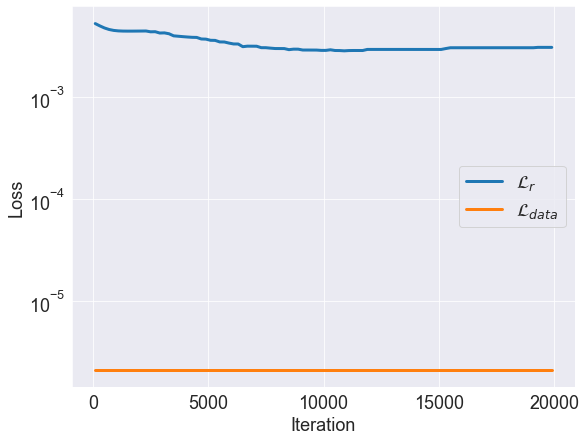

In [13]:
logger = np.load("./logger.npy", allow_pickle=True).item()
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(logger["iter"][::k], logger["loss_res_1"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_ics"][::k], label=r"$\mathcal{L}_{data}$", linewidth=3)
    plt.legend()
    plt.xticks([0, 5000, 10000, 15000, 20000])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss.png', dpi=100)
    plt.show()

In [14]:
# 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

backbone1 = MLP(backbone_layers)  # 主干网络
backbone2 = MLP(backbone_layers) 
backbone3 = MLP(backbone_layers) 
backbone4 = MLP(backbone_layers) 
backbone5 = MLP(backbone_layers) 
pinn = PINN(backbone1,backbone2,backbone3,backbone4,backbone5, mu, sigma)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.load_state_dict(model_state['backbone_state'])
pinn.eval()

# 生成网格
t_res = np.linspace(tmin, tmax, 100)
x_res = np.linspace(xmin, xmax, 100)
X_res = dataset.sample_xy(t_res, x_res)

X_res = np.expand_dims(X_res, axis=2)
X_res = np.repeat(X_res,5,axis=2)
print(X_res.shape)

X_res = torch.from_numpy(X_res).double()
pinn = pinn.cpu().double()
X1_pred,X2_pred,X3_pred,X4_pred,X5_pred = pinn.net_X_res_pred(X_res)

X1_pred = X1_pred.detach().numpy()
X2_pred = X2_pred.detach().numpy()
X3_pred = X3_pred.detach().numpy()
X4_pred = X4_pred.detach().numpy()
X5_pred = X5_pred.detach().numpy()

print(X1_pred)
# X1_error = np.linalg.norm(X1_pred - X1_star) / np.linalg.norm(X1_star) 
# print('Relative l2 error of u: {:.3e}'.format(u_error))

(10000, 2, 5)
[[-0.00388712]
 [-0.0038723 ]
 [-0.00385751]
 ...
 [-0.00255739]
 [-0.00254595]
 [-0.0025346 ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x360 with 0 Axes>

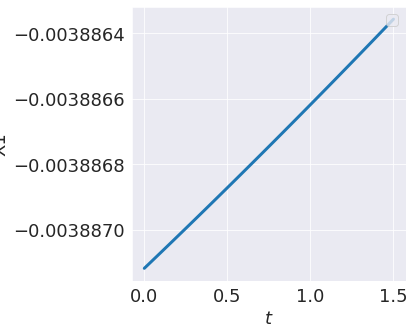

In [15]:
fig = plt.figure(figsize=(6, 5))

plt.rcParams.update({'font.size':18})
with sns.axes_style("darkgrid"):
    fig = plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 3, 1)
    plt.plot(t_res, X1_pred[::100], linewidth=3)
#     plt.scatter(X1_pred[:,0], X1_pred[:,1])
    plt.xlabel('$t$')
    plt.ylabel('X1')
#     plt.xticks([0, 1, 2, 3, 4])
    plt.legend(loc='upper right', fontsize=15)
    plt.tight_layout()
    ax.set_aspect(1./ax.get_data_ratio())